In [292]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

gdp = pd.read_csv('data/gdp.csv')
inflation = pd.read_csv('data/inflation.csv')
unemployment = pd.read_csv('data/unemployment.csv')
yield_data = pd.read_csv('data/yield.csv') 
yield_data['Date'] = pd.to_datetime(yield_data['Date'], errors='coerce')
yield_data.set_index('Date', inplace=True)
recession = pd.read_csv('data/recession_data.csv')


### Yield Data

In [293]:
yield_data = pd.read_csv("data/yield.csv")


# Convert to datetime and set as index
yield_data['Date'] = pd.to_datetime(yield_data['Date'])
yield_data.set_index('Date', inplace=True)


# Replace invalid values with NaN
yield_data.replace(-999.99, pd.NA, inplace=True)

# Drop columns with more than 20% missing values
threshold = 0.2 * len(yield_data)
columns_to_drop = yield_data.columns[yield_data.isnull().sum() > threshold]
yield_data_drop = yield_data.drop(columns=columns_to_drop)

# Rename columns
column_rename_mapping = {
    'BETA0': 'LongTermRate',    # Reflects investor confidence about long-term economic growth and inflation
    'BETA1': 'Slope',           # A negative slope (yield curve inversion) signals a possible recession
}


# https://www.federalreserve.gov/pubs/feds/2006/200628/200628pap.pdf   <=== labels for the columns plus info on data
for i in range(1, 30):
    column_rename_mapping[f'SVENY{i:02d}'] = f'ZeroCouponYield{i}Y'
    column_rename_mapping[f'SVENF{i:02d}'] = f'InstantaneousForwardRate{i}Y'
    yield_data = yield_data.drop(columns=f'SVENPY{i:02d}')
yield_data.rename(columns=column_rename_mapping, inplace=True)


# Resample to monthly frequency (convert from 'B' to 'M')
yield_data = yield_data.resample('M').mean()

# Interpolate missing values 
yield_data.interpolate(method='linear', limit_direction='forward', axis=0, inplace=True)


yield_columns_of_interest = ['Slope', 'LongTermRate'] + \
                      [f'ZeroCouponYield{i}Y' for i in range(1, 11)] + \
                      [f'InstantaneousForwardRate{i}Y' for i in range(1, 11)]


new_yield_data = yield_data[yield_columns_of_interest]
new_yield_data.drop(columns=["InstantaneousForwardRate8Y",'InstantaneousForwardRate9Y','ZeroCouponYield8Y', 'ZeroCouponYield9Y' ])


,Slope,LongTermRate,ZeroCouponYield1Y,ZeroCouponYield2Y,ZeroCouponYield3Y,ZeroCouponYield4Y,ZeroCouponYield5Y,ZeroCouponYield6Y,ZeroCouponYield7Y,ZeroCouponYield10Y,InstantaneousForwardRate1Y,InstantaneousForwardRate2Y,InstantaneousForwardRate3Y,InstantaneousForwardRate4Y,InstantaneousForwardRate5Y,InstantaneousForwardRate6Y,InstantaneousForwardRate7Y,InstantaneousForwardRate10Y
Date,,,,,,,,,,,,,,,,,,
1961-06-30,-1.268221,4.002757,2.974685,3.383562,3.580031,3.684631,3.748146,3.790554,3.820877,NaN,3.533592,3.934585,3.993169,4.001369,4.002562,4.002731,4.002762,NaN
1961-07-31,-1.967420,4.100839,2.841955,3.289770,3.531040,3.668470,3.754025,3.811640,3.852910,NaN,3.436640,3.934995,4.062475,4.092050,4.098790,4.100355,4.100720,NaN
1961-08-31,-1.712356,4.248369,3.001652,3.420465,3.661852,3.802339,3.890426,3.949861,3.992443,NaN,3.522839,4.054435,4.201822,4.237530,4.245861,4.247778,4.248226,NaN
1961-09-30,-1.691689,4.130283,3.043195,3.445030,3.654595,3.770960,3.842475,3.890400,3.924650,NaN,3.581385,4.014040,4.108765,4.126550,4.129645,4.130185,4.130270,NaN
1961-10-31,-1.607382,3.815504,2.962929,3.350962,3.559624,3.674895,3.739548,3.776095,3.796800,NaN,3.489457,3.907943,4.016624,4.014843,3.979167,3.938957,3.904257,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-07-31,3.155800,2.384022,4.843450,4.459173,4.254350,4.154305,4.116082,4.114377,4.134009,4.243741,4.332027,3.902305,3.824605,3.899205,4.032232,4.179814,4.321741,4.651005
2024-08-31,1.158210,4.366392,4.378077,3.932977,3.759623,3.699645,3.691705,3.710009,3.742368,3.870782,3.692477,3.394745,3.455164,3.588405,3.731395,3.870400,4.000941,4.320395
2024-09-30,0.838962,4.658334,3.991825,3.590410,3.487035,3.472960,3.492130,3.527310,3.571365,3.722075,3.269610,3.204920,3.357815,3.501085,3.636180,3.770015,3.900285,4.227915


### Normalize Yield Data

In [294]:
from sklearn.preprocessing import MinMaxScaler


yield_data = new_yield_data

# Flip the dataset so missing data goes to the end
yield_data = yield_data.iloc[::-1]

# Use years 1–7 as inputs and 10Y as targets for missing value prediction
input_columnsIFR = [f"InstantaneousForwardRate{i}Y" for i in range(1, 8)]
target_columnIFR = "InstantaneousForwardRate10Y"
input_columnsZCY = [f"ZeroCouponYield{i}Y" for i in range(1, 8)]
target_columnZCY = "ZeroCouponYield10Y"

# Filter out rows where all inputs (years 1–7) are non-missing
valid_dataIFR = yield_data.dropna(subset=input_columnsIFR)
input_dataIFR = valid_dataIFR[input_columnsIFR].values
target_dataIFR = valid_dataIFR[target_columnIFR].values
valid_dataZCY = yield_data.dropna(subset=input_columnsIFR)
input_dataZCY = valid_dataZCY[input_columnsIFR].values
target_dataZCY = valid_dataZCY[target_columnIFR].values

# Scale the inputs and targets to [0, 1] using MinMaxScaler
scaler_inputsIFR = MinMaxScaler()
scaler_targetsIFR = MinMaxScaler()
scaler_inputsZCY = MinMaxScaler()
scaler_targetsZCY = MinMaxScaler()

scaled_inputsIFR = scaler_inputsIFR.fit_transform(input_dataIFR)
scaled_targetsIFR = scaler_targetsIFR.fit_transform(target_dataIFR.reshape(-1, 1))
scaled_inputsZCY = scaler_inputsZCY.fit_transform(input_dataZCY)
scaled_targetsZCY = scaler_targetsZCY.fit_transform(target_dataZCY.reshape(-1, 1))

missing_data_rowsIFR = yield_data[yield_data[target_columnIFR].isna()]
prediction_inputsIFR = scaler_inputsIFR.transform(missing_data_rowsIFR[input_columnsIFR].values)
missing_data_rowsZCY = yield_data[yield_data[target_columnZCY].isna()]
prediction_inputsZCY = scaler_inputsZCY.transform(missing_data_rowsZCY[input_columnsZCY].values)

# Confirm scaling and data preparation
scaled_inputsIFR.shape, scaled_targetsIFR.shape, scaled_inputsZCY.shape, scaled_targetsZCY.shape

((762, 7), (762, 1), (762, 7), (762, 1))

### Variational Autoencoder to Fill Missing Yield Data

Epoch 1/50
24/24 [==============================] - 0s 3ms/step - loss: 0.1687
Epoch 2/50
24/24 [==============================] - 0s 3ms/step - loss: 0.1617
Epoch 3/50
24/24 [==============================] - 0s 3ms/step - loss: 0.1488
Epoch 4/50
24/24 [==============================] - 0s 3ms/step - loss: 0.1327
Epoch 5/50
24/24 [==============================] - 0s 3ms/step - loss: 0.1232
Epoch 6/50
24/24 [==============================] - 0s 2ms/step - loss: 0.1188
Epoch 7/50
24/24 [==============================] - 0s 2ms/step - loss: 0.1156
Epoch 8/50
24/24 [==============================] - 0s 2ms/step - loss: 0.1142
Epoch 9/50
24/24 [==============================] - 0s 2ms/step - loss: 0.1138
Epoch 10/50
24/24 [==============================] - 0s 2ms/step - loss: 0.1136
Epoch 11/50
24/24 [==============================] - 0s 2ms/step - loss: 0.1135
Epoch 12/50
24/24 [==============================] - 0s 2ms/step - loss: 0.1134
Epoch 13/50
24/24 [==============================

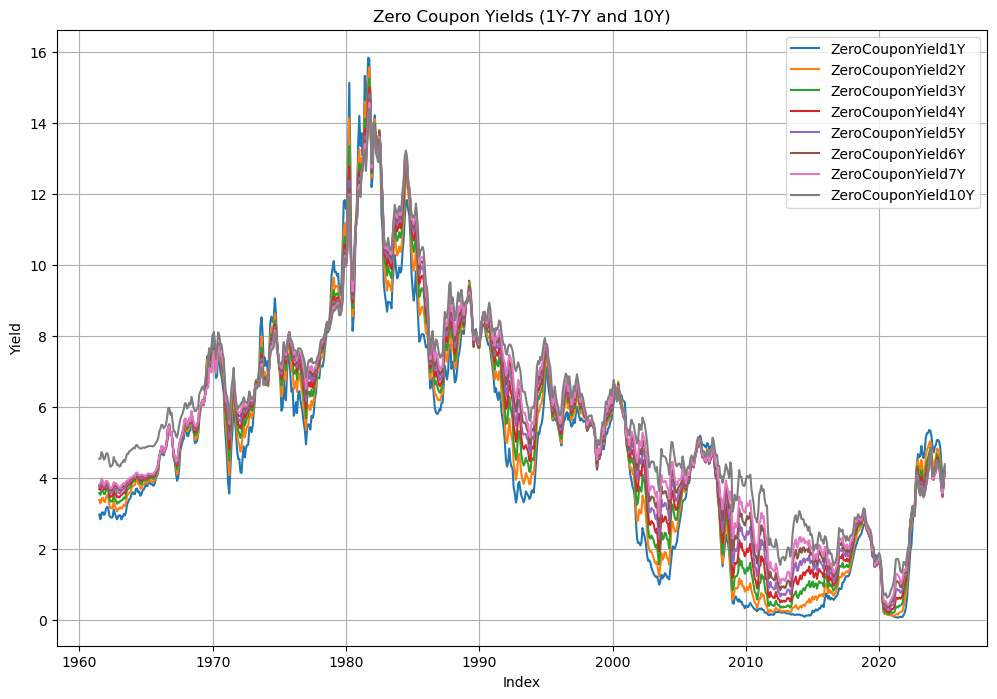

In [295]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Lambda
from tensorflow.keras import backend as K
import tensorflow as tf

# Define the VAE structure
input_dim = scaled_inputsIFR.shape[1]
latent_dim = 2

# Encoder
encoder = Sequential([
    Input(shape=(input_dim,)),
    Dense(32, activation="relu"),
    Dense(16, activation="relu"),
    Dense(latent_dim, name="latent")
])

# Decoder
decoder = Sequential([
    Input(shape=(latent_dim,)),
    Dense(16, activation="relu"),
    Dense(32, activation="relu"),
    Dense(input_dim, activation="sigmoid", name="output")
])

# VAE: connect encoder and decoder
inputs = Input(shape=(input_dim,))
z = encoder(inputs)
reconstructed = decoder(z)

vaeIFR = tf.keras.Model(inputs, reconstructed)
vaeZCY = tf.keras.Model(inputs, reconstructed)

# Loss: reconstruction loss + KL divergence
reconstruction_loss = tf.keras.losses.MeanSquaredError()(inputs, reconstructed)
kl_loss = -0.5 * K.sum(1 + encoder.layers[-1].weights[1] - tf.square(encoder.layers[-1].weights[0]) -
                        tf.exp(encoder.layers[-1].weights[1]), axis=-1)
vae_loss = tf.reduce_mean(reconstruction_loss + kl_loss)

vaeIFR.add_loss(vae_loss)
vaeIFR.compile(optimizer="adam")
vaeZCY.add_loss(vae_loss)
vaeZCY.compile(optimizer="adam")

# Train the VAE
vaeIFR.fit(scaled_inputsIFR, scaled_inputsIFR, epochs=50, batch_size=32, verbose=1)
vaeZCY.fit(scaled_inputsZCY, scaled_inputsZCY, epochs=50, batch_size=32, verbose=1)

# Predict missing 10Y values using the VAE
latent_predictionsIFR = encoder.predict(prediction_inputsIFR)
reconstructed_predictionsIFR = decoder.predict(latent_predictionsIFR)
latent_predictionsZCY = encoder.predict(prediction_inputsZCY)
reconstructed_predictionsZCY = decoder.predict(latent_predictionsZCY)

# Rescale predictions back to the original scale
predicted_10yIFR = scaler_targetsIFR.inverse_transform(reconstructed_predictionsIFR[:, -1].reshape(-1, 1))
predicted_10yZCY = scaler_targetsZCY.inverse_transform(reconstructed_predictionsZCY[:, -1].reshape(-1, 1))

# Flatten the predictions to ensure compatibility
yield_data.loc[yield_data[target_columnIFR].isna(), target_columnIFR] = predicted_10yIFR.flatten()
yield_data.loc[yield_data[target_columnZCY].isna(), target_columnZCY] = predicted_10yZCY.flatten()

# Save the updated dataset in its original format
yield_data = yield_data.iloc[::-1]

# Columns to plot
columns_to_plot = [
    'ZeroCouponYield1Y',
    'ZeroCouponYield2Y',
    'ZeroCouponYield3Y',
    'ZeroCouponYield4Y',
    'ZeroCouponYield5Y',
    'ZeroCouponYield6Y',
    'ZeroCouponYield7Y',
    'ZeroCouponYield10Y'
]


# Plot the columns
plt.figure(figsize=(12, 8))
for col in columns_to_plot:
    plt.plot(yield_data[col], label=col)

# Add labels, legend, and title
plt.xlabel('Index')
plt.ylabel('Yield')
plt.title('Zero Coupon Yields (1Y-7Y and 10Y)')
plt.legend()
plt.grid()
plt.show()

The grey line from 1960-1970 is the predicted past values

### Get Percent Change of Yield Data and Plot

In [296]:
"""yield_data = yield_data.pct_change()
# Columns to plot
columns_to_plot = [
    'ZeroCouponYield1Y',
    'ZeroCouponYield2Y',
    'ZeroCouponYield3Y',
    'ZeroCouponYield4Y',
    'ZeroCouponYield5Y',
    'ZeroCouponYield6Y',
    'ZeroCouponYield7Y',
    'ZeroCouponYield10Y'
]


# Plot the columns
plt.figure(figsize=(12, 8))
for col in columns_to_plot:
    plt.plot(yield_data[col], label=col)

# Add labels, legend, and title
plt.xlabel('Index')
plt.ylabel('Yield')
plt.title('Zero Coupon Yields percent change (1Y-7Y and 10Y)')
plt.legend()
plt.grid()
plt.show()
"""

"yield_data = yield_data.pct_change()\n# Columns to plot\ncolumns_to_plot = [\n    'ZeroCouponYield1Y',\n    'ZeroCouponYield2Y',\n    'ZeroCouponYield3Y',\n    'ZeroCouponYield4Y',\n    'ZeroCouponYield5Y',\n    'ZeroCouponYield6Y',\n    'ZeroCouponYield7Y',\n    'ZeroCouponYield10Y'\n]\n\n\n# Plot the columns\nplt.figure(figsize=(12, 8))\nfor col in columns_to_plot:\n    plt.plot(yield_data[col], label=col)\n\n# Add labels, legend, and title\nplt.xlabel('Index')\nplt.ylabel('Yield')\nplt.title('Zero Coupon Yields percent change (1Y-7Y and 10Y)')\nplt.legend()\nplt.grid()\nplt.show()\n"

### Unemployment Data

            overall_rate  men_rate  women_rate  men_16_17_rate  \
date                                                             
1948-01-31           3.4       3.4         3.3             9.7   
1948-02-29           3.8       3.6         4.5            13.0   
1948-03-31           4.0       3.8         4.4            14.0   
1948-04-30           3.9       3.8         4.3            11.6   
1948-05-31           3.5       3.5         3.7             7.1   

            women_16_17_rate  men_16_19_rate  women_16_19_rate  \
date                                                             
1948-01-31               8.8             9.4               7.2   
1948-02-29              13.2            10.8               8.9   
1948-03-31              11.4            11.9               8.6   
1948-04-30              10.6             9.8               9.2   
1948-05-31               5.4             7.6               6.1   

            men_18_19_rate  women_18_19_rate  men_16_24_rate  ...  \
date 

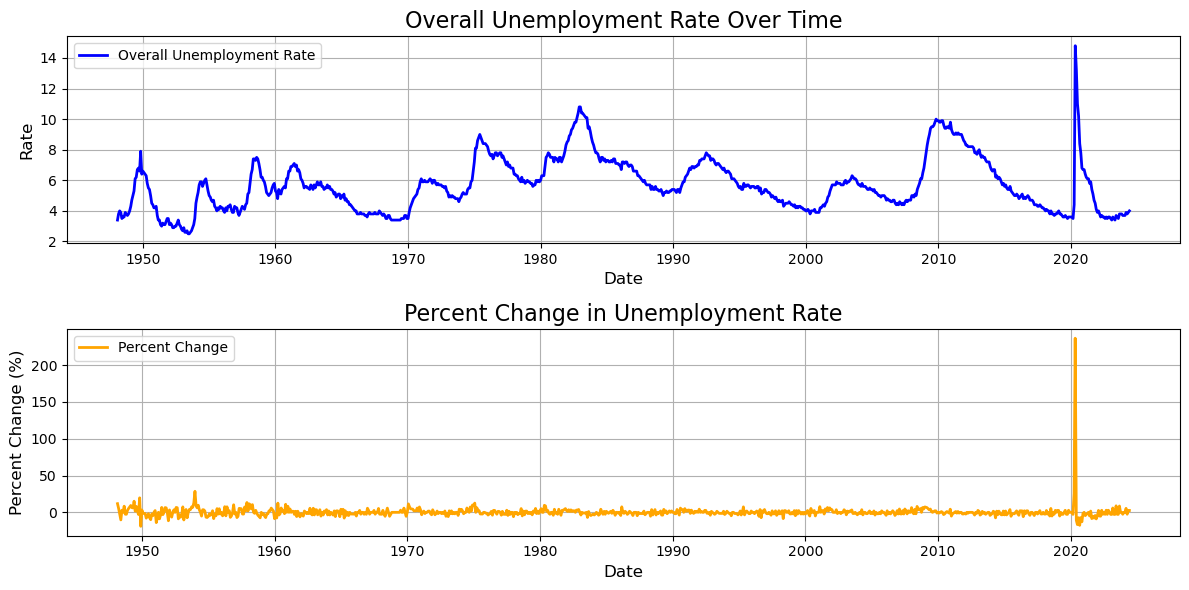

In [297]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert to datetime and set index
unemployment['date'] = pd.to_datetime(unemployment['date'], errors='coerce')
unemployment.set_index('date', inplace=True)
unemployment.sort_index(inplace=True)

# Resample to monthly frequency
unemployment = unemployment.resample('M').mean()

# Find and fill all missing data while dropping columns that don't meet the threshold
threshold = 0.2 * len(unemployment)
columns_to_drop = unemployment.columns[unemployment.isnull().sum() > threshold]
unemployment = unemployment.drop(columns=columns_to_drop)
unemployment.interpolate(method='linear', inplace=True)  # Use linear interpolation for filling NA values

# Calculate percent change for 'overall_rate'
unemployment['unemployment_percent_change'] = unemployment['overall_rate'].pct_change() * 100  # Multiply by 100 for percentage format

# Display the first few rows
print(unemployment.head())

# Plot normalized overall rate
plt.figure(figsize=(12, 6))

# Original Unemployment Rate
plt.subplot(2, 1, 1)
plt.plot(unemployment.index, unemployment['overall_rate'], label='Overall Unemployment Rate', color='blue', linewidth=2)
plt.title('Overall Unemployment Rate Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Rate', fontsize=12)
plt.legend()
plt.grid(True)

# Percent Change
plt.subplot(2, 1, 2)
plt.plot(unemployment.index, unemployment['unemployment_percent_change'], label='Percent Change', color='orange', linewidth=2)
plt.title('Percent Change in Unemployment Rate', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Percent Change (%)', fontsize=12)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Inflation Data

            value  inflation_percent_change
date                                       
1947-02-28  21.62                  0.006518
1947-03-31  22.00                  0.017576
1947-04-30  22.00                  0.000000
1947-05-31  21.95                 -0.002273
1947-06-30  22.08                  0.005923


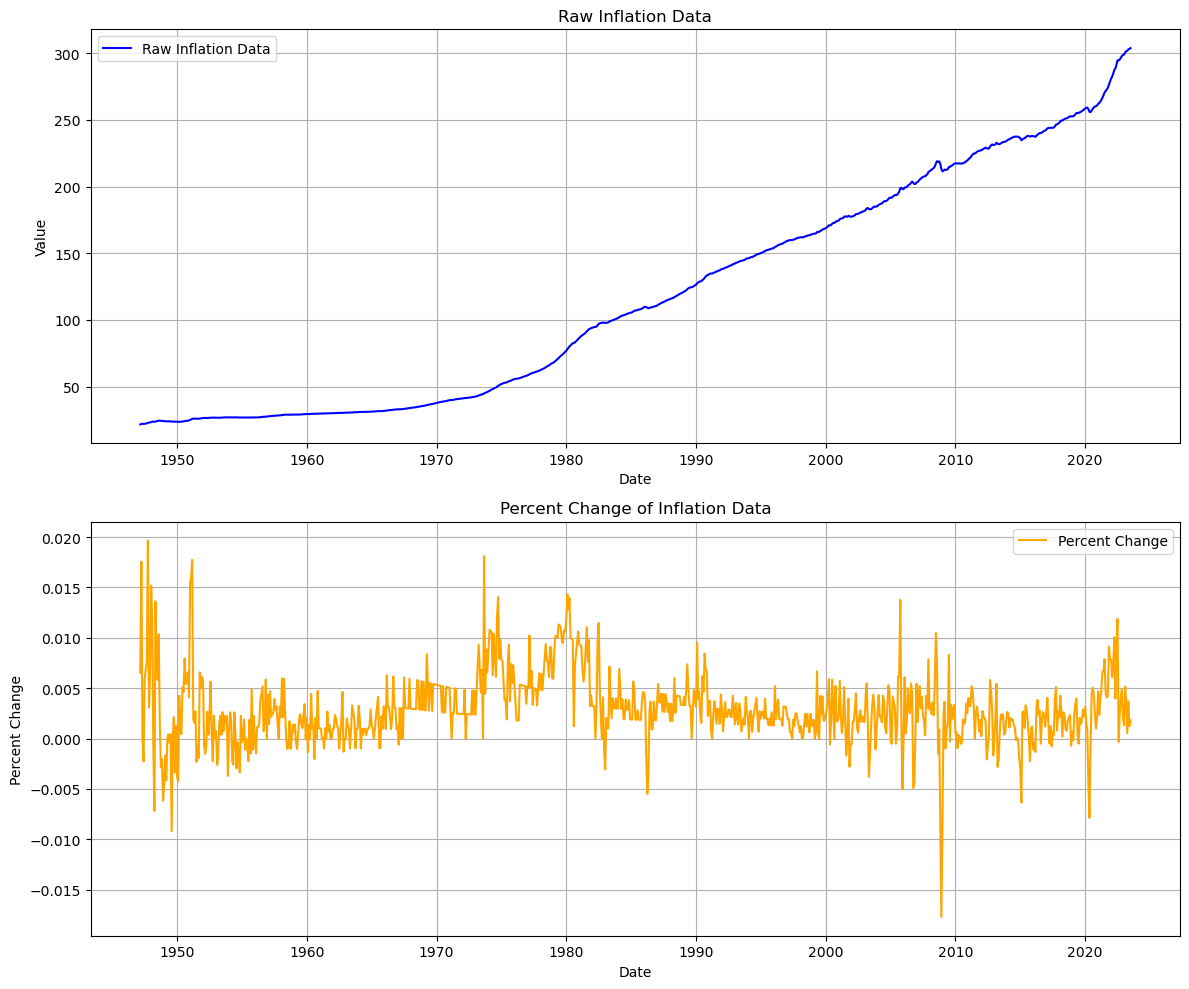

In [298]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'date' column is set as index
inflation['date'] = pd.to_datetime(inflation['date'], errors='coerce')
inflation.set_index('date', inplace=True)
inflation.sort_index(inplace=True)

# Resample to ensure monthly frequency
inflation = inflation.resample('M').mean()

# Fill missing values using linear interpolation
inflation.interpolate(method='linear', inplace=True)

# Calculate the percent change
inflation['inflation_percent_change'] = inflation['value'].pct_change()

# Drop NaN values resulting from percent change calculation
inflation = inflation.dropna(subset=['inflation_percent_change'])

print(inflation.head())

# Plot the normalized original data and percent change
plt.figure(figsize=(12, 10))

# Raw Inflation Data
plt.subplot(2, 1, 1)
plt.plot(inflation.index, inflation['value'], label='Raw Inflation Data', color='blue')
plt.title('Raw Inflation Data')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.grid(True)

# Percent Change Data
plt.subplot(2, 1, 2)
plt.plot(inflation.index, inflation['inflation_percent_change'], label='Percent Change', color='orange')
plt.title('Percent Change of Inflation Data')
plt.xlabel('Date')
plt.ylabel('Percent Change')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### GDP Data

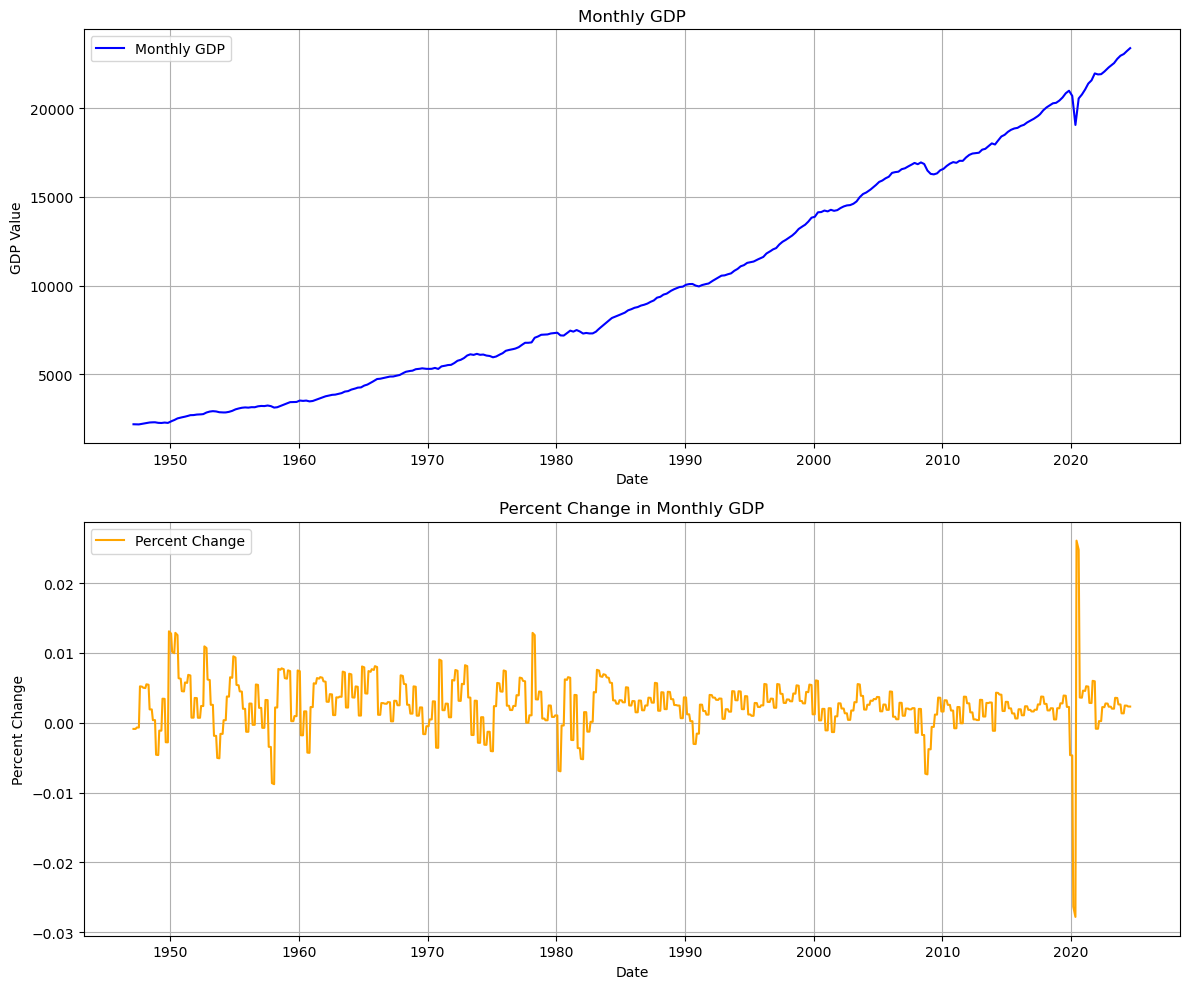

In [299]:
# Convert DATE to datetime and set as index
gdp = pd.read_csv('data/gdp.csv')
gdp['DATE'] = pd.to_datetime(gdp['DATE'])
gdp.set_index('DATE', inplace=True)

# Resample to monthly frequency
gdp = gdp.resample('M').mean()
gdp = gdp.interpolate(method='linear')

# Calculate percent change
gdp['gdp_percent_change'] = gdp['GDPC1'].pct_change() 

# Drop NaN values from percent change
gdp = gdp.dropna(subset=['gdp_percent_change'])

# Visualization
plt.figure(figsize=(12, 10))

# Monthly GDP
plt.subplot(2, 1, 1)
plt.plot(gdp.index, gdp['GDPC1'], label='Monthly GDP', color='blue')
plt.title('Monthly GDP')
plt.xlabel('Date')
plt.ylabel('GDP Value')
plt.legend()
plt.grid(True)

# Percent Change in GDP
plt.subplot(2, 1, 2)
plt.plot(gdp.index, gdp['gdp_percent_change'], label='Percent Change', color='orange')
plt.title('Percent Change in Monthly GDP')
plt.xlabel('Date')
plt.ylabel('Percent Change')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Recession Data

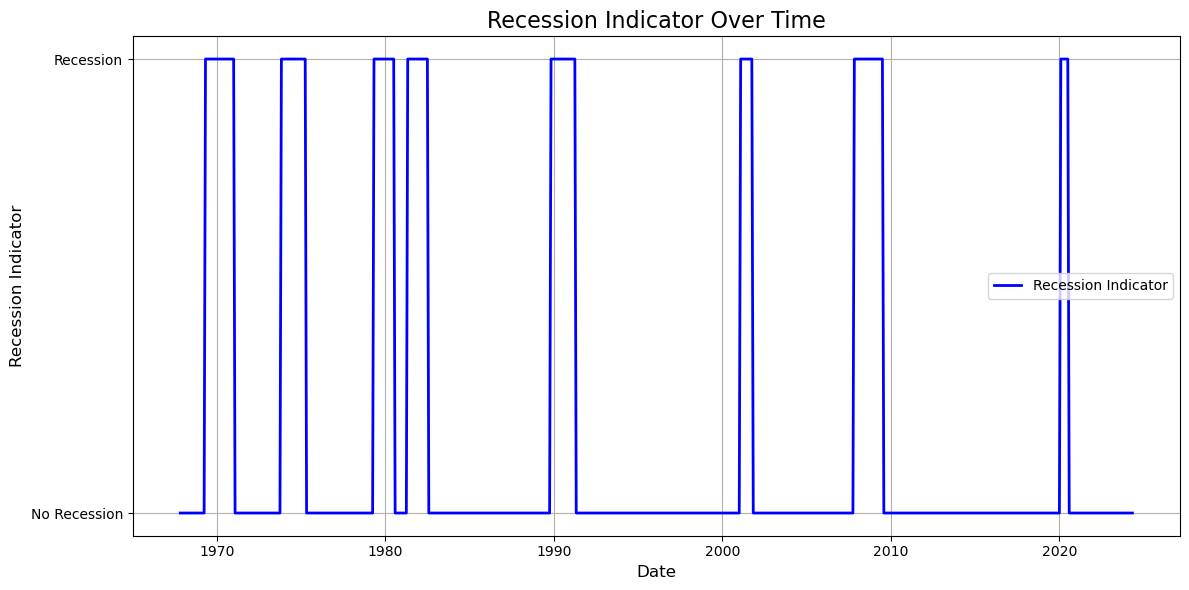

In [300]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
recession['DATE'] = pd.to_datetime(recession['DATE'])
recession.set_index('DATE', inplace=True)

# Rename the JHDUSRGDPBR column to Recession for consistency
recession_data = recession.rename(columns={'JHDUSRGDPBR': 'Recession'})

# Resample to monthly frequency and forward-fill missing values
recession_data = recession_data.resample('M').ffill()

# Plot the recession data
plt.figure(figsize=(12, 6))
plt.plot(recession_data.index, recession_data['Recession'], label='Recession Indicator', color='blue', linewidth=2)

# Add title and labels
plt.title('Recession Indicator Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Recession Indicator', fontsize=12)

# Customize y-axis ticks for binary values (0 and 1)
plt.yticks([0, 1], labels=['No Recession', 'Recession'])

# Add grid and legend
plt.grid(True)
plt.legend(fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


### Data Date Range

In [301]:
import pandas as pd

# GDP Dataset
print("GDP Dataset:")
gdp.index = pd.to_datetime(gdp.index, errors='coerce')  
print("GDP Index Type:", gdp.index.dtype)
print("GDP Date Range:", gdp.index.min(), "to", gdp.index.max())

# Inflation Dataset
print("\nInflation Dataset:")
inflation['date'] = pd.to_datetime(inflation.index, errors='coerce')  
inflation.set_index('date', inplace=True)  
print("Inflation Index Type:", inflation.index.dtype)
print("Inflation Date Range:", inflation.index.min(), "to", inflation.index.max())

# Unemployment Dataset
print("\nUnemployment Dataset:")
unemployment['date'] = pd.to_datetime(unemployment.index, errors='coerce')  
unemployment.set_index('date', inplace=True)  
print("Unemployment Index Type:", unemployment.index.dtype)
print("Unemployment Date Range:", unemployment.index.min(), "to", unemployment.index.max())

# Yield Curve Dataset
print("\nYield Curve Dataset:")
yield_data['Date'] = pd.to_datetime(yield_data.index, errors='coerce')  
yield_data.set_index('Date', inplace=True)  
print("Yield Curve Index Type:", yield_data.index.dtype)
print("Yield Curve Date Range:", yield_data.index.min(), "to", yield_data.index.max())

# Recession Dataset
print("\nRecession Dataset:")
recession_data['DATE'] = pd.to_datetime(recession_data.index, errors='coerce')  
recession_data.set_index('DATE', inplace=True)  
print("Recession Index Type:", recession_data.index.dtype)
print("Recession Date Range:", recession_data.index.min(), "to", recession_data.index.max())


GDP Dataset:
GDP Index Type: datetime64[ns]
GDP Date Range: 1947-02-28 00:00:00 to 2024-07-31 00:00:00

Inflation Dataset:
Inflation Index Type: datetime64[ns]
Inflation Date Range: 1947-02-28 00:00:00 to 2023-06-30 00:00:00

Unemployment Dataset:
Unemployment Index Type: datetime64[ns]
Unemployment Date Range: 1948-01-31 00:00:00 to 2024-05-31 00:00:00

Yield Curve Dataset:
Yield Curve Index Type: datetime64[ns]
Yield Curve Date Range: 1961-06-30 00:00:00 to 2024-11-30 00:00:00

Recession Dataset:
Recession Index Type: datetime64[ns]
Recession Date Range: 1967-10-31 00:00:00 to 2024-04-30 00:00:00


### Align and Merge Datasets

In [302]:
# Align the date range to the common period
common_start_date = max(
    gdp.index.min(),
    inflation.index.min(),
    unemployment.index.min(),
    yield_data.index.min(),
    recession_data.index.min()  # Include recession data in alignment
)
common_end_date = min(
    gdp.index.max(),
    inflation.index.max(),
    unemployment.index.max(),
    yield_data.index.max(),
    recession_data.index.max()  # Include recession data in alignment
)

# Clip datasets to the common date range
gdp_aligned = gdp.loc[common_start_date:common_end_date, ['gdp_percent_change']]
inflation_aligned = inflation.loc[common_start_date:common_end_date, ['inflation_percent_change']]
unemployment_aligned = unemployment.loc[common_start_date:common_end_date, ['overall_rate']]
recession_aligned = recession_data.loc[common_start_date:common_end_date, ['Recession']]  # Clip recession data

# Columns of interest for yield_data
yield_columns_of_interest = ['LongTermRate', 'Slope', 'ZeroCouponYield1Y',
                        #'ZeroCouponYield2Y', 'ZeroCouponYield3Y',
                        #'ZeroCouponYield4Y', 'ZeroCouponYield5Y',
                        #'ZeroCouponYield6Y', 'ZeroCouponYield7Y',
                        'ZeroCouponYield10Y']

# Filter and clip yield_data to the common date range
yield_data_clipped = yield_data.loc[common_start_date:common_end_date, yield_columns_of_interest]

# Merge datasets
merged_data = (
    gdp_aligned
    .merge(inflation_aligned, left_index=True, right_index=True, how='inner')
    .merge(unemployment_aligned, left_index=True, right_index=True, how='inner')
    .merge(yield_data_clipped, left_index=True, right_index=True, how='inner')
    .merge(recession_aligned, left_index=True, right_index=True, how='inner')  # Add recession data
)

# Drop first row which contains mostly NaN values
merged_data = merged_data.iloc[1:]

# Display the merged data
print("Merged Data Summary:")
print(merged_data.head())

# Save the merged dataset
output_path = 'data/merged_data.csv'
merged_data.to_csv(output_path)


Merged Data Summary:
            gdp_percent_change  inflation_percent_change  overall_rate  \
DATE                                                                     
1967-11-30            0.006798                  0.005935           3.9   
1967-12-31            0.006752                  0.002950           3.8   
1968-01-31            0.006706                  0.002941           3.7   
1968-02-29            0.005568                  0.002933           3.8   
1968-03-31            0.005537                  0.002924           3.7   

            LongTermRate      Slope  ZeroCouponYield1Y  ZeroCouponYield10Y  \
DATE                                                                         
1967-11-30      5.780432  -0.722486           5.363020            6.104068   
1967-12-31      5.759107   0.257391           5.482600            6.107653   
1968-01-31      5.552207  -0.448540           5.199345            5.959924   
1968-02-29      5.646273   6.229295           5.180384            6.00